<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session14/blob/main/part1_session14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [27]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [28]:
!pip install folium==0.2.1

In [29]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers --quiet

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [32]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [33]:
!ls /drive/My\ Drive/TSAI_data/Squad2.0

checkpoint-final  dev-v2.0.json  predictions.json  train-v2.0.json


In [34]:
import sys
sys.path.append('/drive/My Drive/TSAI_data/Squad2.0')

In [35]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2021-08-14 08:31:28--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py.1’

utils_squad.py.1    100%[===================>]  40.56K  --.-KB/s    in 0.002s  

2021-08-14 08:31:28 (18.3 MB/s) - ‘utils_squad.py.1’ saved [41529/41529]

--2021-08-14 08:31:28--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [36]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
input_file = '/drive/My Drive/TSAI_data/Squad2.0/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [39]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [40]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
print(len(train_data))
train_data.head()

130319


,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [41]:
#we take only 20% of training data for quick training 
train_data = train_data.sample(frac=0.20)
len(train_data)

26064

In [42]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
16487,5acd507907355d001abf3cde,In which year was the 20th satellite launched?,"[On, July, 25,, 2015,, the, 18th, and, 19th, s...",,-1,-1,True


In [43]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [44]:
print_squad_sample(train_data)

CONTEXT: 
Arsenal have appeared in a number of media "firsts". On 22 January 1927, their
match at Highbury against Sheffield United was the first English League match to be
broadcast live on radio. A decade later, on 16 September 1937, an exhibition match
between Arsenal's first team and the reserves was the first football match in the
world to be televised live. Arsenal also featured in the first edition of the
BBC's Match of the Day, which screened highlights of their match against Liverpool at
Anfield on 22 August 1964. BSkyB's coverage of Arsenal's January 2010 match against Manchester
United was the first live public broadcast of a sports event on 3D television.
QUESTION:                                                                                            ANSWER:
To what first broadcast did Arsenal provide match highlights?                                        BBC's Match of the Day
In what year did BskyB televise their first Arsenal game?                                  

In [45]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
1365,56d3997e59d6e414001467ef,What form does Temperley feel that Chopin's ba...,"[J., Barrie, Jones, suggests, that, ""amongst, ...",departure and return,67,69,False,105,79
113104,572ff02b04bcaa1900d76eec,What Arabic book is Ibn Tufail noted for writing?,"[Ibn, Tufail, (Abubacer), and, Ibn, al-Nafis, ...",Hayy ibn Yaqdhan (Philosophus Autodidactus),19,23,False,142,49
14716,5a10e2b206e79900185c344e,How do VISP's customers access the Internet?,"[A, virtual, ISP, (VISP), is, an, operation, t...",,-1,-1,True,55,44
58504,5a15b05aa54d4200185294a4,What was censorship a regulatory model for?,"[On, the, assumption, that, intellectual, prop...",,-1,-1,True,134,43
121476,5a77acd1b73996001af5a4ef,What type of epistemology served as the founda...,"[Regardless, of, the, way, the, tension, betwe...",,-1,-1,True,154,116


In [46]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.22360343769184%


In [47]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 888109.87B/s]


In [48]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [49]:
path = '/drive/My Drive/TSAI_data/Squad2.0/'

In [50]:
cached_features_file = os.path.join(path, 'cached_{}'.format('train'))

In [51]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [52]:
# features = convert_examples_to_features(examples=examples,
#                                         tokenizer=tokenizer,
#                                         max_seq_length=max_seq_length,
#                                         doc_stride=doc_stride,
#                                         max_query_length=max_query_length,
#                                         is_training=True)
# torch.save(features, cached_features_file)

In [53]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [54]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [55]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [56]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/TSAI_data/Squad2.0/checkpoint*-[0-9]*'))

In [57]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [58]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/TSAI_data/Squad2.0/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:13<00:00, 33407265.20B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [59]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0179,  0.0201,  0.0146,  ..., -0.0168,  0.0005,  0.0230],
        [-0.0120,  0.0122,  0.0213,  ..., -0.0259,  0.0285,  0.0139]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [60]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [61]:
num_train_epochs = 2

# print("***** Running training *****")
# print("  Num examples = %d" % len(dataset))
# print("  Num Epochs = %d" % num_train_epochs)
# print("  Batch size = %d" % batch_size)
# print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        # output_dir = '/drive/My Drive/TSAI_data/Squad2.0/checkpoint-{}'.format(global_step)
        # if not os.path.exists(output_dir):
        #     os.makedirs(output_dir)
        # model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        # model_to_save.save_pretrained(output_dir)
        # torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        # print("Saving model checkpoint to %s" % output_dir)

Iteration:   0%|          | 0/9016 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  11%|█         | 1001/9016 [07:25<59:42,  2.24it/s]

Train loss: 1.8215731245279312



Iteration:  22%|██▏       | 2001/9016 [14:50<52:14,  2.24it/s]

Train loss: 1.5803610279262066



Iteration:  33%|███▎      | 3001/9016 [22:16<44:37,  2.25it/s]

Train loss: 1.4726014304161072



Iteration:  44%|████▍     | 4001/9016 [29:41<37:11,  2.25it/s]

Train loss: 1.3995458724349736



Iteration:  55%|█████▌    | 5001/9016 [37:07<29:48,  2.24it/s]

Train loss: 1.3432809360951186



Iteration:  67%|██████▋   | 6001/9016 [44:31<22:22,  2.25it/s]

Train loss: 1.2996587165420255



Iteration:  78%|███████▊  | 7001/9016 [51:56<14:58,  2.24it/s]

Train loss: 1.2657221806198358



Iteration:  89%|████████▊ | 8001/9016 [59:21<07:31,  2.25it/s]

Train loss: 1.2374250815380365



Iteration: 100%|█████████▉| 9001/9016 [1:06:46<00:06,  2.25it/s]

Train loss: 1.2124706713176436



Epoch: 100%|██████████| 2/2 [1:06:55<00:00, 2007.84s/it]


In [62]:
global_step

9015

In [63]:
output_dir = '/drive/My Drive/TSAI_data/Squad2.0/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))

In [64]:
train_loss_set_ckpt = torch.load('/drive/My Drive/TSAI_data/Squad2.0/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)


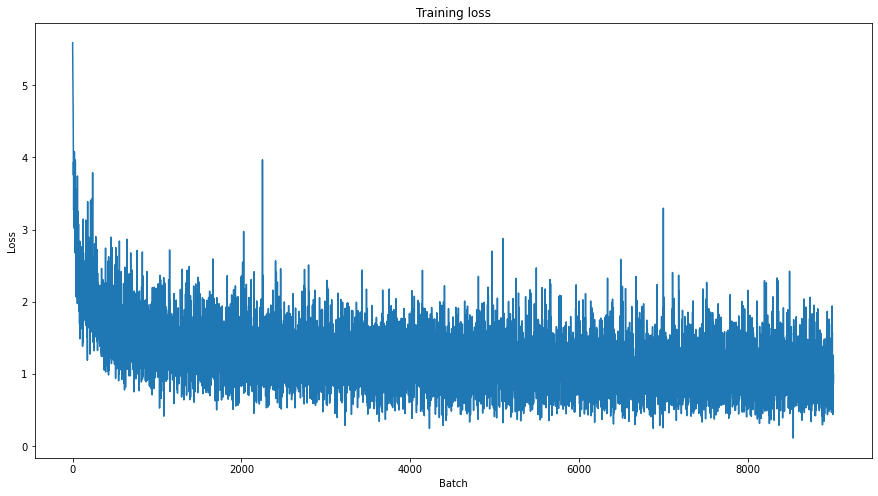

In [65]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [66]:
input_file = '/drive/My Drive/TSAI_data/Squad2.0/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = os.path.join(path, 'cached_{}'.format('validation'))

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [67]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [68]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [69]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/drive/My Drive/TSAI_data/Squad2.0//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/drive/My Drive/TSAI_data/Squad2.0/predictions.json"
  output_nbest_file = "/drive/My Drive/TSAI_data/Squad2.0/nbest_predictions.json"
  output_null_log_odds_file = "/drive/My Drive/TSAI_data/Squad2.0/null_odds.json"
  output_dir = "/drive/My Drive/TSAI_data/Squad2.0/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [70]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [02:01<00:00,  7.01it/s]


{
  "exact": 69.96546786827255,
  "f1": 73.08229065875776,
  "total": 11873,
  "HasAns_exact": 61.85897435897436,
  "HasAns_f1": 68.10155819693462,
  "HasAns_total": 5928,
  "NoAns_exact": 78.04878048780488,
  "NoAns_f1": 78.04878048780488,
  "NoAns_total": 5945,
  "best_exact": 70.26025435862883,
  "best_exact_thresh": -0.6219072341918945,
  "best_f1": 73.21205801017358,
  "best_f1_thresh": -0.42403125762939453
}


In [71]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 69.96546786827255}, {'f1': 73.08229065875776}, {'total': 11873}, {'HasAns_exact': 61.85897435897436}, {'HasAns_f1': 68.10155819693462}, {'HasAns_total': 5928}, {'NoAns_exact': 78.04878048780488}, {'NoAns_f1': 78.04878048780488}, {'NoAns_total': 5945}, {'best_exact': 70.26025435862883}, {'best_exact_thresh': -0.6219072341918945}, {'best_f1': 73.21205801017358}, {'best_f1_thresh': -0.42403125762939453}]


**Evaluate on any text**

In [72]:
import json
with open("/drive/My Drive/TSAI_data/Squad2.0/predictions.json" ) as f:
    best_predictions = json.load(f)

In [75]:
import random
#showing results only with answer
for example in random.sample(val_examples, 50):
    qas_id = example.qas_id
    question_text = example.question_text
    answer_text = best_predictions[qas_id]
    if len(answer_text) >1:
      print(f'question       >> {question_text}')
      print(f'predicted answer >> {answer_text}')

      print()

question       >> When was Dali defended by the Yuan?
predicted answer >> 1253

question       >> What molecules of the adaptive immune system only exist in jawed vertebrates?
predicted answer >> immunoglobulins and T cell receptors

question       >> What does the capabilities approach look at poverty as a form of?
predicted answer >> capability deprivation

question       >> How much can the SP alter income tax in Scotland?
predicted answer >> up to 3 pence in the pound

question       >> The French thought bringing what would uplift other regions?
predicted answer >> Christianity and French culture

question       >> What organization is the IPCC a part of?
predicted answer >> World Meteorological Organization

question       >> At what pressure is water heated in the Rankine cycle?
predicted answer >> high pressure

question       >> What limits the Rankine cycle's efficiency?
predicted answer >> the working fluid

question       >> In what year did Joseph Priestley recognize oxyge